## Encoder-only architecture - BERT

- Self-attention mechanism
- Feed-forward neural networks
- Layer normalization and residual connections


there are two version of BERT cased and uncased. 
The cased version retains the original case of the input text, while the uncased version converts all characters to lowercase.

In [2]:
from transformers import BertModel, BertTokenizer
import torch
import matplotlib.pyplot as plot

C:\Users\david\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name = "bert-base-uncased"
model = BertModel.from_pretrained(model_name)  ### we are downloading the pretrained model 
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Embedding layer is responsible to create the representation of the input tokens, includes:
Word embeddings: map each of the 30522 vocabulary tokens to 786 dimensional vector
Position Embeddings: add positional information to each token using a 512-length sequence (bert support only a sequence of at most 512 tokens )
Token Type Embeddings: adds embeddings to distinguish between segments ( Sentence A , Sentece B ) [SEP]


## BERT Tokenization with WordPiece

WordPiece is a sub word tokenizer technique. Split the out-of-vocabulary in more sub words

In [5]:
tokenizer = BertTokenizer.from_pretrained(model_name)     ## we are download the Bert tokenizer

sentence = "it was her responsibility to superinted the entire construction process"

# Tokenize the sentece 
tokens = tokenizer.tokenize(sentence)  ### the Bert model uses the WordPiece tokenizer
print("Tokens: ", tokens)

token_ids = tokenizer.convert_tokens_to_ids(tokens)   ### the word super ### int ##ed  is out of the vocabulary
print("Token IDs:", token_ids)

Tokens:  ['it', 'was', 'her', 'responsibility', 'to', 'super', '##int', '##ed', 'the', 'entire', 'construction', 'process']
Token IDs: [2009, 2001, 2014, 5368, 2000, 3565, 18447, 2098, 1996, 2972, 2810, 2832]


tokens ##end and end (representing the self-contained word "end") are encoded as different tokens

In [7]:
tokenizer.convert_tokens_to_ids(["##end", "end"])

[10497, 2203]

## Special Tokens

[CLS] token (Classification Token)
- added at the beginning of every input sequence

[PAD] token is used to pad sequences so they all have the same length within a batch. The attention mechanism then ignores these [PAD] tokens

In [21]:
sentence1 = "This is a short sentence."
tokens_single = tokenizer(sentence1, return_tensors='pt', padding='max_length', max_length=10)
print(type(tokens_single['input_ids']))
print(tokens_single['input_ids'].shape)
print(tokens_single['input_ids'].size())


# Display tokenized output and input IDs
print("Single Sentence Tokenization:")
print("[CLS] has token number ", tokens_single["input_ids"][0][0])
print("Tokens:", tokenizer.convert_ids_to_tokens(tokens_single['input_ids'][0]))  ####the first token is the CLS
print("Input IDs:", tokens_single['input_ids'][0])

<class 'torch.Tensor'>
torch.Size([1, 10])
torch.Size([1, 10])
Single Sentence Tokenization:
[CLS] has token number  tensor(101)
Tokens: ['[CLS]', 'this', 'is', 'a', 'short', 'sentence', '.', '[SEP]', '[PAD]', '[PAD]']
Input IDs: tensor([ 101, 2023, 2003, 1037, 2460, 6251, 1012,  102,    0,    0])


(Note that, if we want to truncate the sentences to max_length tokens, we should additionally pass truncation=True).

[SEP] Token (Separator Token)

In [22]:
sentence2 = "But now it is a little longer."
tokens_pair = tokenizer(sentence1, sentence2, return_tensors='pt', padding='max_length', max_length=20)

# Display tokenized output and input IDs
print("\nTwo Sentences Tokenization:")
print("Tokens:", tokenizer.convert_ids_to_tokens(tokens_pair['input_ids'][0]))
print("Input IDs:", tokens_pair['input_ids'][0])


Two Sentences Tokenization:
Tokens: ['[CLS]', 'this', 'is', 'a', 'short', 'sentence', '.', '[SEP]', 'but', 'now', 'it', 'is', 'a', 'little', 'longer', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]']
Input IDs: tensor([ 101, 2023, 2003, 1037, 2460, 6251, 1012,  102, 2021, 2085, 2009, 2003,
        1037, 2210, 2936, 1012,  102,    0,    0,    0])


In [23]:
tokens_pair["token_type_ids"]  #### the zeros for the first sentence and 1 for the second, the last 3 zeros the pad tokens

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])

[MASK] Token
- The [MASK] token is used during training for the Masked Language Modeling (MLM) task, where a percentage of tokens are masked and the model must predict them based on the context.
- This token is rarely used during inference but is crucial in pre-training BERT.
- The [MASK] token (like other special tokens) can be included directly in the input text -- the tokenizer will assign the corresponding token.

In [24]:
tokenizer.convert_ids_to_tokens(103)

'[MASK]'

In [18]:
tokenizer.tokenize("I am happy", include_special_tokens=True)

print(tokenizer.mask_token_id)

tokens

Keyword arguments {'include_special_tokens': True} not recognized.


103


['it',
 'was',
 'her',
 'responsibility',
 'to',
 'super',
 '##int',
 '##ed',
 'the',
 'entire',
 'construction',
 'process']

In [ ]:
### previous sentence
tokens

['it',
 'was',
 'her',
 'responsibility',
 'to',
 'super',
 '##int',
 '##ed',
 'the',
 'entire',
 'construction',
 'process']

In [29]:
# show a mask token 
mask_token = tokenizer.mask_token 
print(mask_token)
mask_token_id = tokenizer.convert_tokens_to_ids(mask_token)
print(mask_token_id)


# Encode a text
text = "I do not know how the sentence will [MASK]."

tokens = tokenizer.tokenize(text)

for token, token_id in zip(tokenizer.convert_tokens_to_ids(tokens), tokens):
    print(f"{token_id} => {token}")

[MASK]
103
i => 1045
do => 2079
not => 2025
know => 2113
how => 2129
the => 1996
sentence => 6251
will => 2097
[MASK] => 103
. => 1012


## Positional Encodings in Transformers
There are two common approaches for implementing absolute positional encodings:

## 1. Static Sinusoidal Positional Encodings
## 2. Learned Positional Embeddings

BERT uses the second approach: learned positional embeddings. During the training process, BERT learns a set of positional vectors corresponding to token positions up to a maximum length (typically 512). These embeddings are added to the token embeddings to provide position information

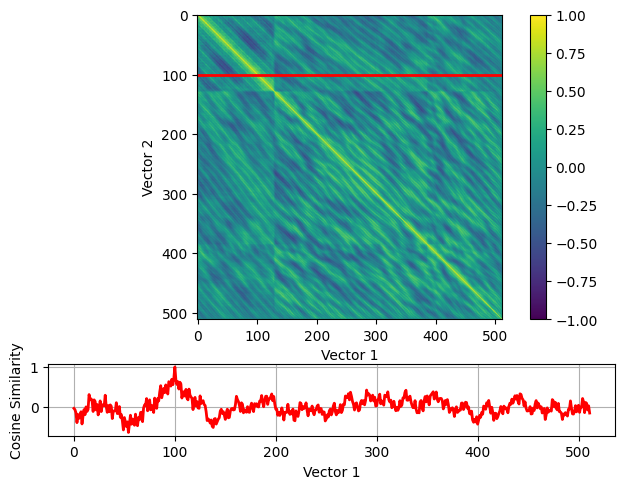

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertModel

# Load pre-trained BERT model
model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name)    ### we are gettin the pretrained model 

# Position embeddings are stored in the embedding layer as 'position_embeddings.weight'
positional_encodings = model.embeddings.position_embeddings.weight.detach().cpu().numpy()

# Compute cosine similarity between positional encodings
cosine_sim = cosine_similarity(positional_encodings)

fig, ax = plt.subplot_mosaic("""
AAA
AAA
AAA
BBB""")

plt.tight_layout()

# Plot the cosine similarity heatmap
ax["A"].set_aspect('equal')
cbar = ax["A"].imshow(cosine_sim, cmap='viridis', vmin=-1, vmax=1)
ax["A"].set_xlabel('Vector 1')
ax["A"].set_ylabel('Vector 2')
ax["A"].axhline(100, c='r', lw=2)
# add colorbar
fig.colorbar(cbar, ax=ax["A"])


# Plot the cosine similarity for a specific row

ax["B"].plot(cosine_sim[100], c='r', lw=2)
ax["B"].set_xlabel('Vector 1')
ax["B"].set_ylabel('Cosine Similarity')
ax["B"].grid()